# Group 2

## Import

In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

from xgboost import XGBRegressor
from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from pdpbox import pdp
import shap

In [46]:
df = pd.read_excel('dataproject2024.xlsx')
df

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0


## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

**We use the unknown model's predictions (`PD`) as the target variable and use original features to train our surrogate model**

In [84]:
y = df['PD']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### First surrogate: LinearRegression

First we build the surrogate model

In [85]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.025293393693871593
R-squared: 0.42325844480117003


In [86]:
# rajouter commentaire performance nulle du modèle surrogate 

Then we interpret the coefficients

           Feature  Coefficient
0       Job tenure    -0.002953
1              Age    -0.001269
2        Car price    -0.000021
3   Funding amount     0.000026
4     Down payment     0.081968
5    Loan duration     0.001142
6  Monthly payment     0.291974
7     Credit event     0.315471
8          Married    -0.072892
9        Homeowner    -0.064714


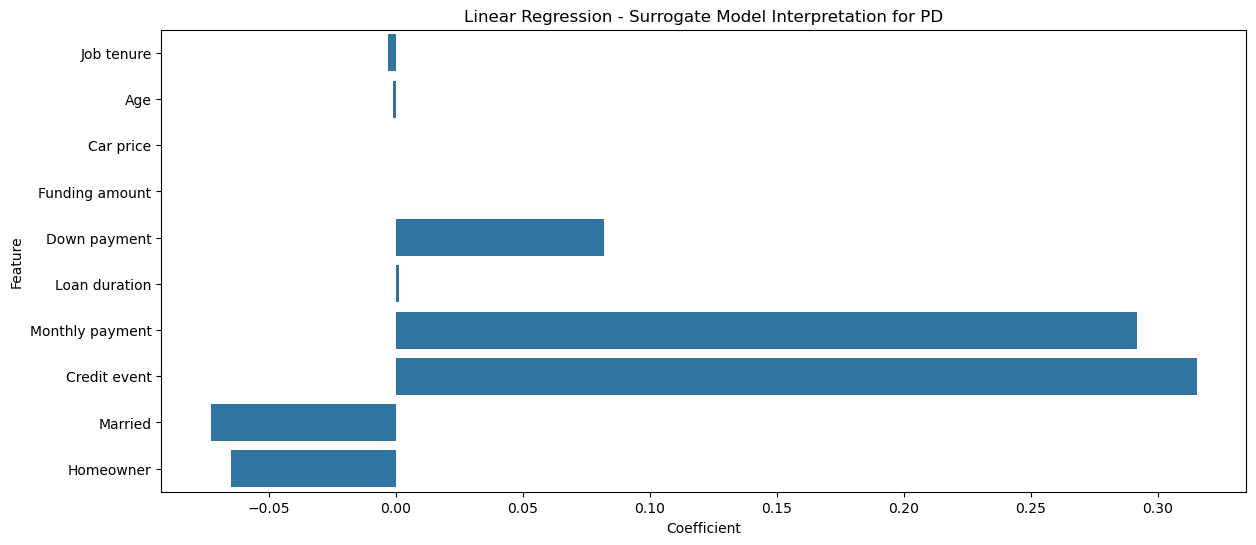

In [49]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)

# plotting
plt.figure(figsize=(14,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression - Surrogate Model Interpretation for PD')
plt.show()

This plot helps in interpreting the unknown model! We see how different features have an impact on the estimated default probability. For instance:

- **Credit event** has the largest positive coefficient. This means that if a credit event occurred it significantly increases the probability of default. This suggests that credit history plays a crucial role in predicting default likelihood

- **Monthly payment** also has a big positive effect meaning that higher monthly payments are associated with a higher probability of default. This could be due to the financial burden of higher loan payments on the borrower

- **Marital status** and **Homeownership** on the other hand have negative coefficients implying that being married or a homeowner reduces the probability of default. These factors might indicate more financial stability, leading to lower risk

### Second surrogate: DecisionTreeRegressor

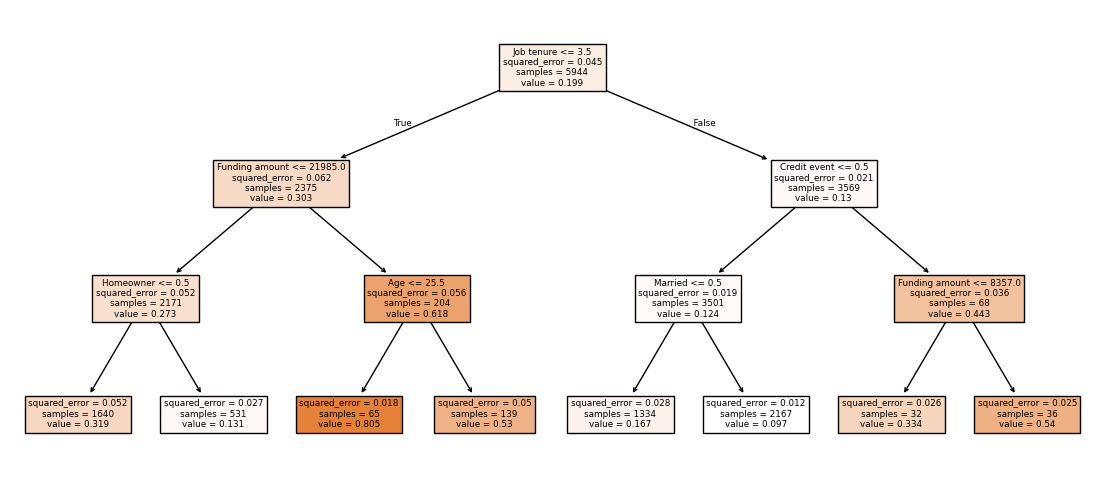

Train Score: 0.35382098105428017
Test Score: 0.30911991669819894


In [54]:
surrogate_model = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate_model.fit(X_train, y_train)

plt.figure(figsize=(14,6))
plot_tree(surrogate_model, feature_names=X.columns, filled=True)
plt.show()

train_score = surrogate_model.score(X_train, y_train)
test_score = surrogate_model.score(X_test, y_test)

print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

In [76]:
# add commentaire feature importance

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

We often use XGBoost for its powerful and flexible ML algorithms but in fact it can be considered a black-box model and although it often leads to very good results, it is often hard to interpret them !

In [7]:
df.columns

Index(['ID', 'Job tenure', 'Age', 'Car price', 'Funding amount',
       'Down payment', 'Loan duration', 'Monthly payment', 'Credit event',
       'Married', 'Homeowner', 'Default (y)', 'Pred_default (y_hat)', 'PD',
       'Group'],
      dtype='object')

In [92]:
y = df['Default (y)']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8129205921938089
Confusion Matrix:
[[1143   62]
 [ 216   65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1205
           1       0.51      0.23      0.32       281

    accuracy                           0.81      1486
   macro avg       0.68      0.59      0.61      1486
weighted avg       0.78      0.81      0.78      1486



In order to make the model more performant (and more complex as we are creating a black-box !) we hyper-parameter tune our model using optuna:

In [11]:
def objective(trial):
    # tuning hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'base_score': trial.suggest_float('base_score', 0.5, 0.7),
        'random_state': 42
    }

    xgb_model = XGBClassifier(**param, objective='binary:logistic')
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgb_model.predict(X_test)

    return 1 - accuracy_score(y_test, y_pred)  # minimize error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-09-25 14:29:45,518] A new study created in memory with name: no-name-c284b4fc-98be-48fa-a97d-83b352563fc5
[I 2024-09-25 14:29:45,694] Trial 0 finished with value: 0.3216689098250336 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.0032402876169332013, 'subsample': 0.967831613397631, 'colsample_bytree': 0.9639105646257407, 'gamma': 6.504852224403843, 'reg_alpha': 1.1108523547544743e-06, 'reg_lambda': 4.227148551355274e-07, 'min_child_weight': 7, 'scale_pos_weight': 2.0844131327898436, 'eta': 0.26209820370562276, 'base_score': 0.6346636708228963}. Best is trial 0 with value: 0.3216689098250336.
[I 2024-09-25 14:29:46,076] Trial 1 finished with value: 0.4751009421265141 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.0021507224461529283, 'subsample': 0.5831184260838108, 'colsample_bytree': 0.618483803128398, 'gamma': 4.685463251851622, 'reg_alpha': 2.370290570169402e-05, 'reg_lambda': 3.4797211078000077e-06, 'min_child_weight': 5, '

In [95]:
best_params = study.best_params
print(f"Best hyperparameters: {study.best_params}")

xgb_model = XGBClassifier(**best_params, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Best hyperparameters: {'n_estimators': 1207, 'max_depth': 10, 'learning_rate': 0.018923561402806252, 'subsample': 0.8428650336687261, 'colsample_bytree': 0.41972448144699925, 'gamma': 4.950418679537689, 'reg_alpha': 0.9432012569880011, 'reg_lambda': 0.3721025076784593, 'min_child_weight': 6, 'scale_pos_weight': 1.162637674990414, 'eta': 0.15922328211666892, 'base_score': 0.6035832183085174}
Accuracy: 0.8324360699865411
Confusion Matrix:
[[1165   40]
 [ 209   72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1205
           1       0.64      0.26      0.37       281

    accuracy                           0.83      1486
   macro avg       0.75      0.61      0.63      1486
weighted avg       0.81      0.83      0.80      1486



## Step 3: Analyze the forecasting performance of your own model.

In [96]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8324360699865411
Confusion Matrix:
[[1165   40]
 [ 209   72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1205
           1       0.64      0.26      0.37       281

    accuracy                           0.83      1486
   macro avg       0.75      0.61      0.63      1486
weighted avg       0.81      0.83      0.80      1486



Visualize Predicted vs. Actual Values

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# Calculate Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6428571428571429
Recall: 0.25622775800711745
F1 Score: 0.366412213740458


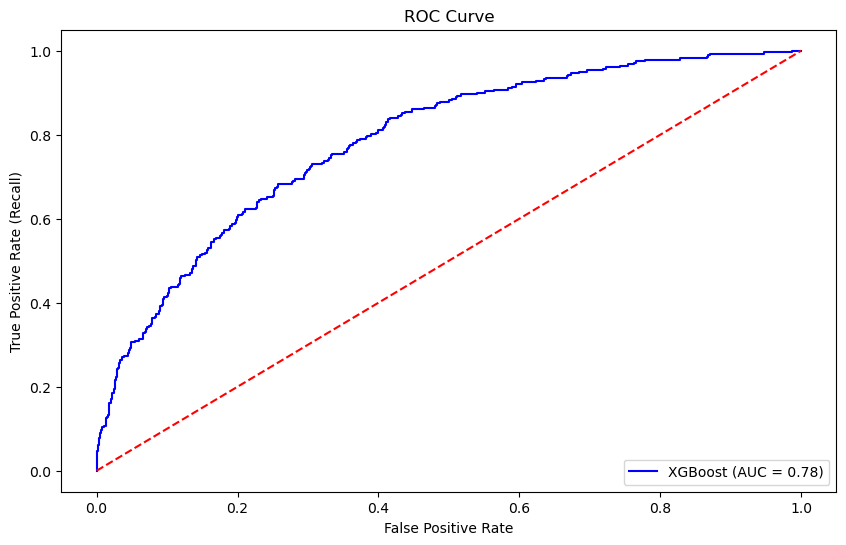

ROC AUC Score: 0.7840197280016538


In [21]:
# ROC Curve and AUC
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc}")

**0.78** indicates that the model is doing well at distinguishing between default vs non-default

## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_surrogate = xgb_model.predict(X_train)

### Logistic Regression surrogate

In [109]:
lr_surrogate = LogisticRegression()
lr_surrogate.fit(X_train, y_surrogate)

# predictions for surrogate model
y_surrogate_pred_proba = lr_surrogate.predict_proba(X_test) # predict_proba for logloss metric
y_surrogate_pred = lr_surrogate.predict(X_test)

# predictions for black-box (xgb) model
y_blackbox_pred_proba = xgb_model.predict_proba(X_test) # predict_proba for logloss metric
y_blackbox_pred = xgb_model.predict(X_test)

### Coefficients for Logistic Regression surrogate

Surrogate vs. Black Box:
  Accuracy: 0.9475
  F1 Score: 0.9459
  Log Loss: 0.1522

Surrogate vs. Real Y:
  Accuracy: 0.8257
  F1 Score: 0.7898
  Log Loss: 0.9008

Black Box vs. Real Y:
  Accuracy: 0.8324
  F1 Score: 0.8019
  Log Loss: 0.4062

Feature Importance:
           Feature  Importance
8          Married   -2.434937
7     Credit event    2.025851
9        Homeowner   -1.672705
0       Job tenure   -0.298746
4     Down payment   -0.131310
1              Age   -0.090491
6  Monthly payment    0.075342
5    Loan duration    0.011162
3   Funding amount    0.000631
2        Car price   -0.000464


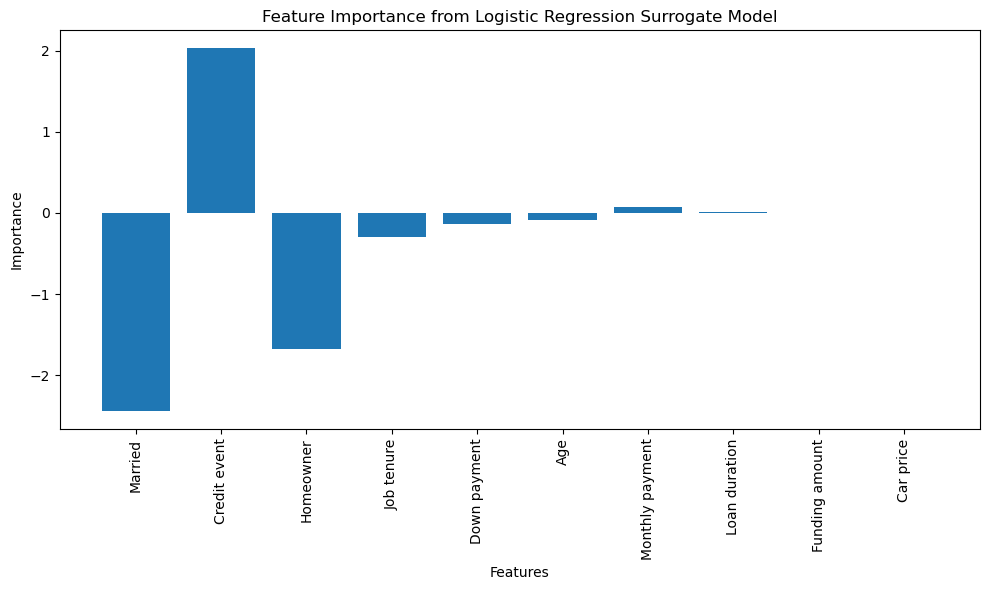

In [112]:
# Surrogate vs Black Box
accuracy_surrogate_blackbox = accuracy_score(y_blackbox_pred, y_surrogate_pred)
f1_surrogate_blackbox = f1_score(y_blackbox_pred, y_surrogate_pred, average='weighted')
logloss_surrogate_blackbox = log_loss(y_blackbox_pred, y_surrogate_pred_proba)

# Surrogate vs Real Y
accuracy_surrogate_real = accuracy_score(y_test, y_surrogate_pred)
f1_surrogate_real = f1_score(y_test, y_surrogate_pred, average='weighted')
logloss_surrogate_real = log_loss(y_test, y_surrogate_pred_proba)

# Black Box vs Real Y (for reference)
accuracy_blackbox_real = accuracy_score(y_test, y_blackbox_pred)
f1_blackbox_real = f1_score(y_test, y_blackbox_pred, average='weighted')
logloss_blackbox_real = log_loss(y_test, y_blackbox_pred_proba)

print("Surrogate vs. Black Box:")
print(f"  Accuracy: {accuracy_surrogate_blackbox:.4f}")
print(f"  F1 Score: {f1_surrogate_blackbox:.4f}")
print(f"  Log Loss: {logloss_surrogate_blackbox:.4f}")

print("\nSurrogate vs. Real Y:")
print(f"  Accuracy: {accuracy_surrogate_real:.4f}")
print(f"  F1 Score: {f1_surrogate_real:.4f}")
print(f"  Log Loss: {logloss_surrogate_real:.4f}")

print("\nBlack Box vs. Real Y:")
print(f"  Accuracy: {accuracy_blackbox_real:.4f}")
print(f"  F1 Score: {f1_blackbox_real:.4f}")
print(f"  Log Loss: {logloss_blackbox_real:.4f}")

# Step 6: Interpret the surrogate model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lr_surrogate.coef_[0]
})
feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance from Logistic Regression Surrogate Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The Logistic Regression surrogate provides insight into how each feature affects the probability of default:

- **Credit Event** has the largest positive coefficient (2.03), indicating that having a credit event significantly increases the probability of default
- **Monthly Payment** and **Funding Amount** also show positive coefficients, suggesting higher values increase default risk, though their impact is smaller
- **Marital Status** and **Homeownership** have large negative coefficients, indicating that being married (-2.43) or a homeowner (-1.67) significantly reduces the probability of default, likely reflecting greater financial stability
- **Job Tenure** has a modest negative effect, implying longer employment reduces default risk

### Let's now evaluate the predictions of 

Surrogate vs. Black Box:
  Accuracy: 0.9475
  F1 Score: 0.9459
  Log Loss: 0.1522

Surrogate vs. Real Y:
  Accuracy: 0.8257
  F1 Score: 0.7898
  Log Loss: 0.9008

Black Box vs. Real Y:
  Accuracy: 0.8324
  F1 Score: 0.8019
  Log Loss: 0.4062

Feature Importance:
           Feature  Importance
8          Married   -2.434937
7     Credit event    2.025851
9        Homeowner   -1.672705
0       Job tenure   -0.298746
4     Down payment   -0.131310
1              Age   -0.090491
6  Monthly payment    0.075342
5    Loan duration    0.011162
3   Funding amount    0.000631
2        Car price   -0.000464


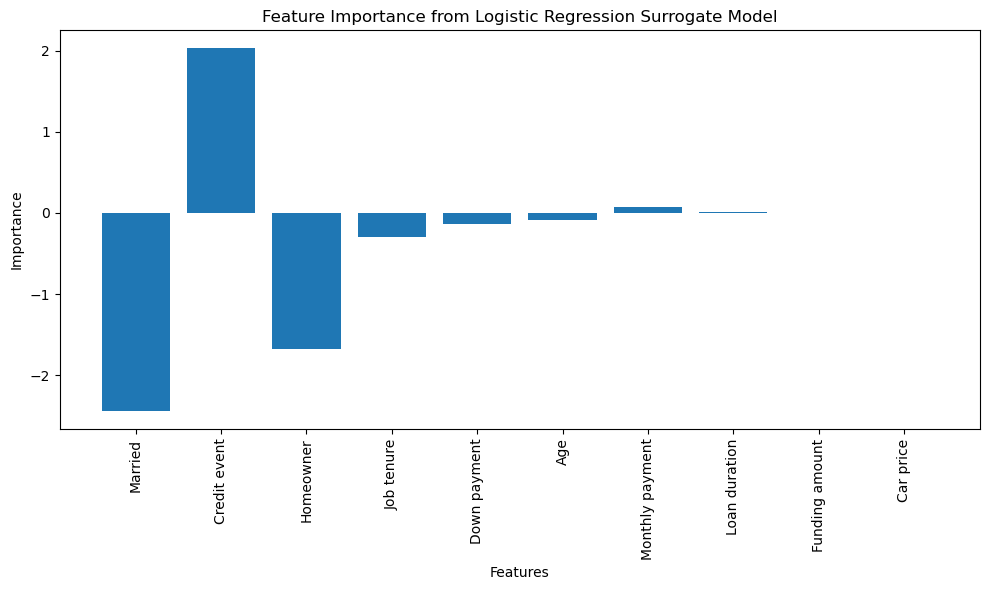

In [106]:


# # Evaluate surrogate accuracy
# log_reg_accuracy = accuracy_score(y_surrogate_class, log_reg_surrogate.predict(X_train))
# print(f"Logistic Regression Surrogate Accuracy on training data: {log_reg_accuracy}")

### Decision tree classifier surrogate model

In [101]:
from sklearn.tree import DecisionTreeClassifier

dt_surrogate_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_surrogate_classifier.fit(X_train, y_surrogate_class)

y_dt_class_pred = dt_surrogate_classifier.predict(X_test)

### Feature importance for the Decision Tree classifier surrogate

Decision Tree Surrogate Classifier Train Accuracy: 0.9535666218034994
Decision Tree Surrogate Classifier Test Accuracy: 0.8909825033647375

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1309
           1       0.59      0.29      0.39       177

    accuracy                           0.89      1486
   macro avg       0.75      0.63      0.66      1486
weighted avg       0.87      0.89      0.87      1486

Decision Tree Classifier Feature Importances:
           Feature  Importance
1              Age    0.358221
0       Job tenure    0.181030
5    Loan duration    0.158854
3   Funding amount    0.130756
7     Credit event    0.108617
6  Monthly payment    0.062521
2        Car price    0.000000
4     Down payment    0.000000
8          Married    0.000000
9        Homeowner    0.000000


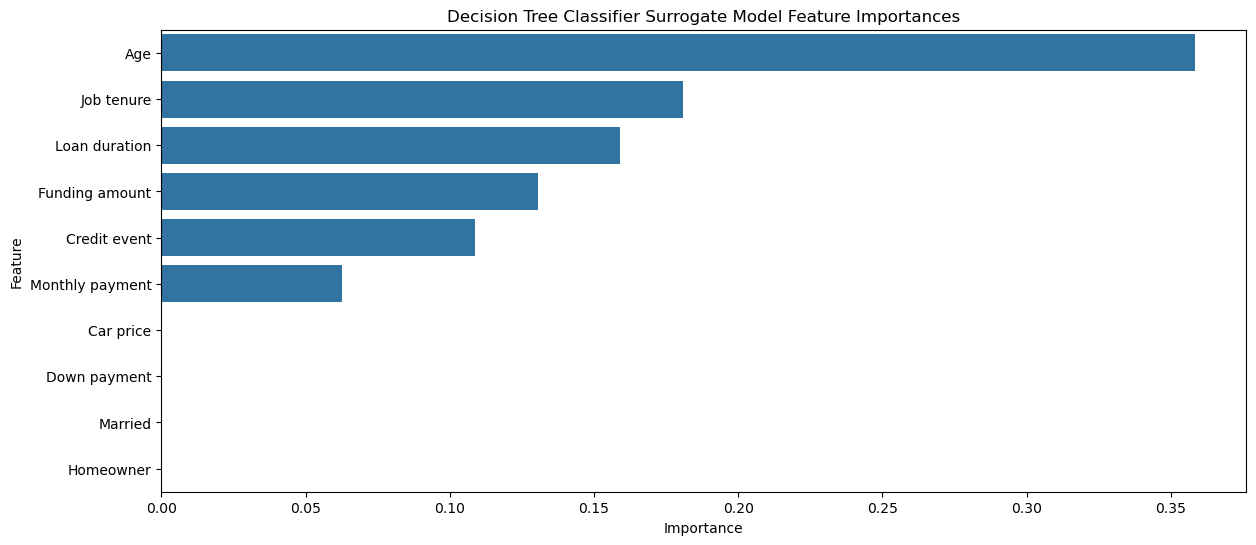

In [75]:
y_test_binary = (y_test >= 0.5).astype(int) # fixing error continuous ?

dt_surrogate_accuracy = accuracy_score(y_surrogate_class, dt_surrogate_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test_binary, y_dt_class_pred)

print(f"Decision Tree Surrogate Classifier Train Accuracy: {dt_surrogate_accuracy}")
print(f"Decision Tree Surrogate Classifier Test Accuracy: {test_accuracy}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test_binary, y_dt_class_pred))

feature_importance_dt_class = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_surrogate_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Classifier Feature Importances:")
print(feature_importance_dt_class)

# feature importances
plt.figure(figsize=(14,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt_class)
plt.title('Decision Tree Classifier Surrogate Model Feature Importances')
plt.show()

The Decision Tree Classifier surrogate achieved a high train accuracy (95.36%) and a good test accuracy (89.10%), indicating that it approximates the XGBoost model’s behavior effectively on unseen data

Regarding feature importance, **Age** (35.8%), **Job Tenure** (18.1%), and **Loan Duration** (15.9%) are the most significant features influencing the default predictions. Features such as **Car Price**, **Down Payment**, **Marital Status**, and **Homeownership** had no impact in this surrogate model

## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

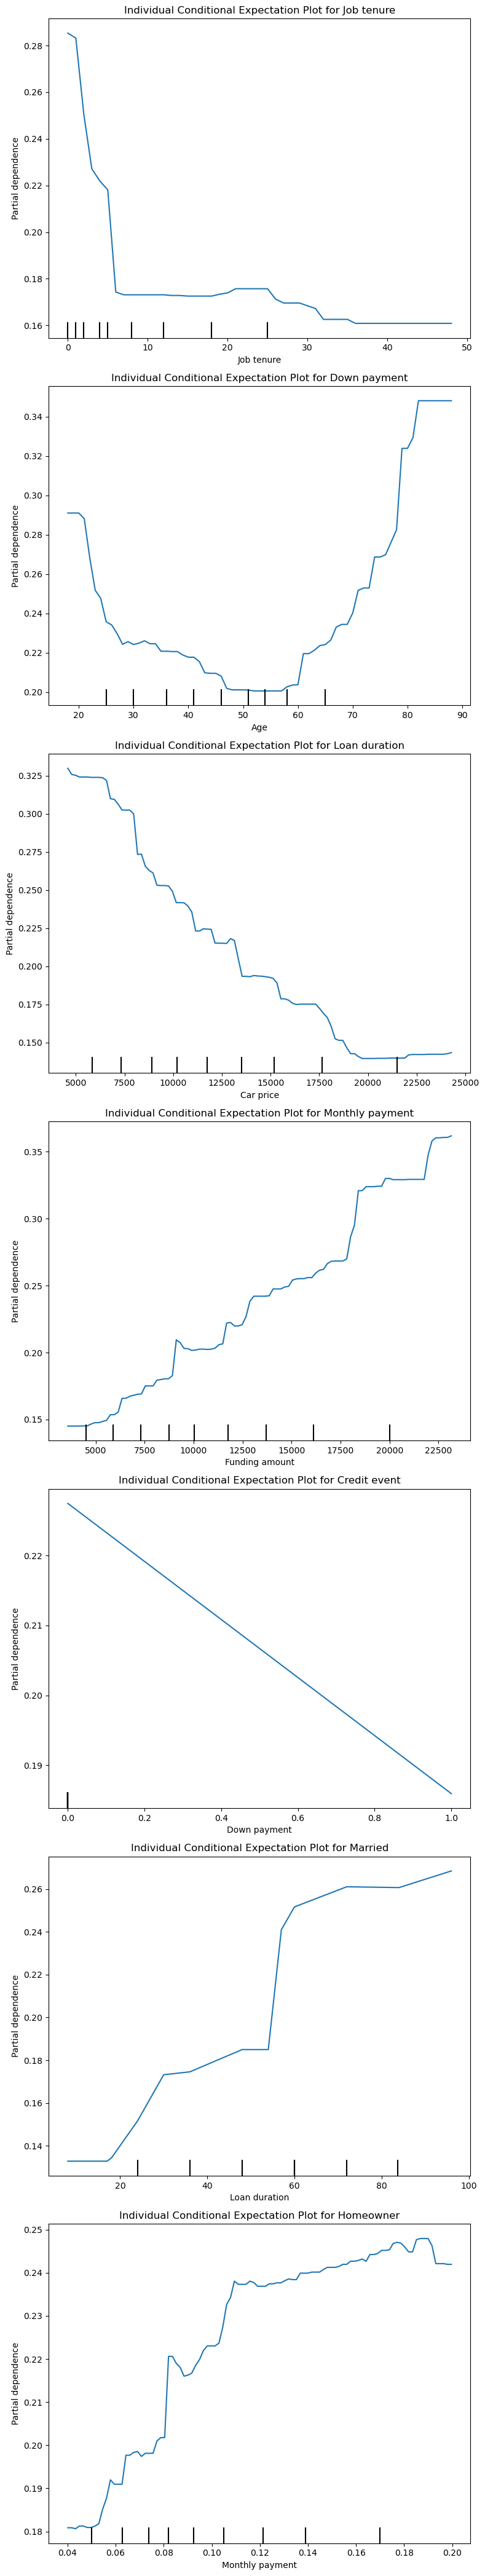

In [114]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Choose features for the ICE plot (replace with the feature names from your dataset)
features = ['Job tenure', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']

# Generate ICE plot for each feature
fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 6 * len(features)))

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(xgb_model, X_test, [i], ax=axs[i])
    axs[i].set_title(f'Individual Conditional Expectation Plot for {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Predicted Probability of Default')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

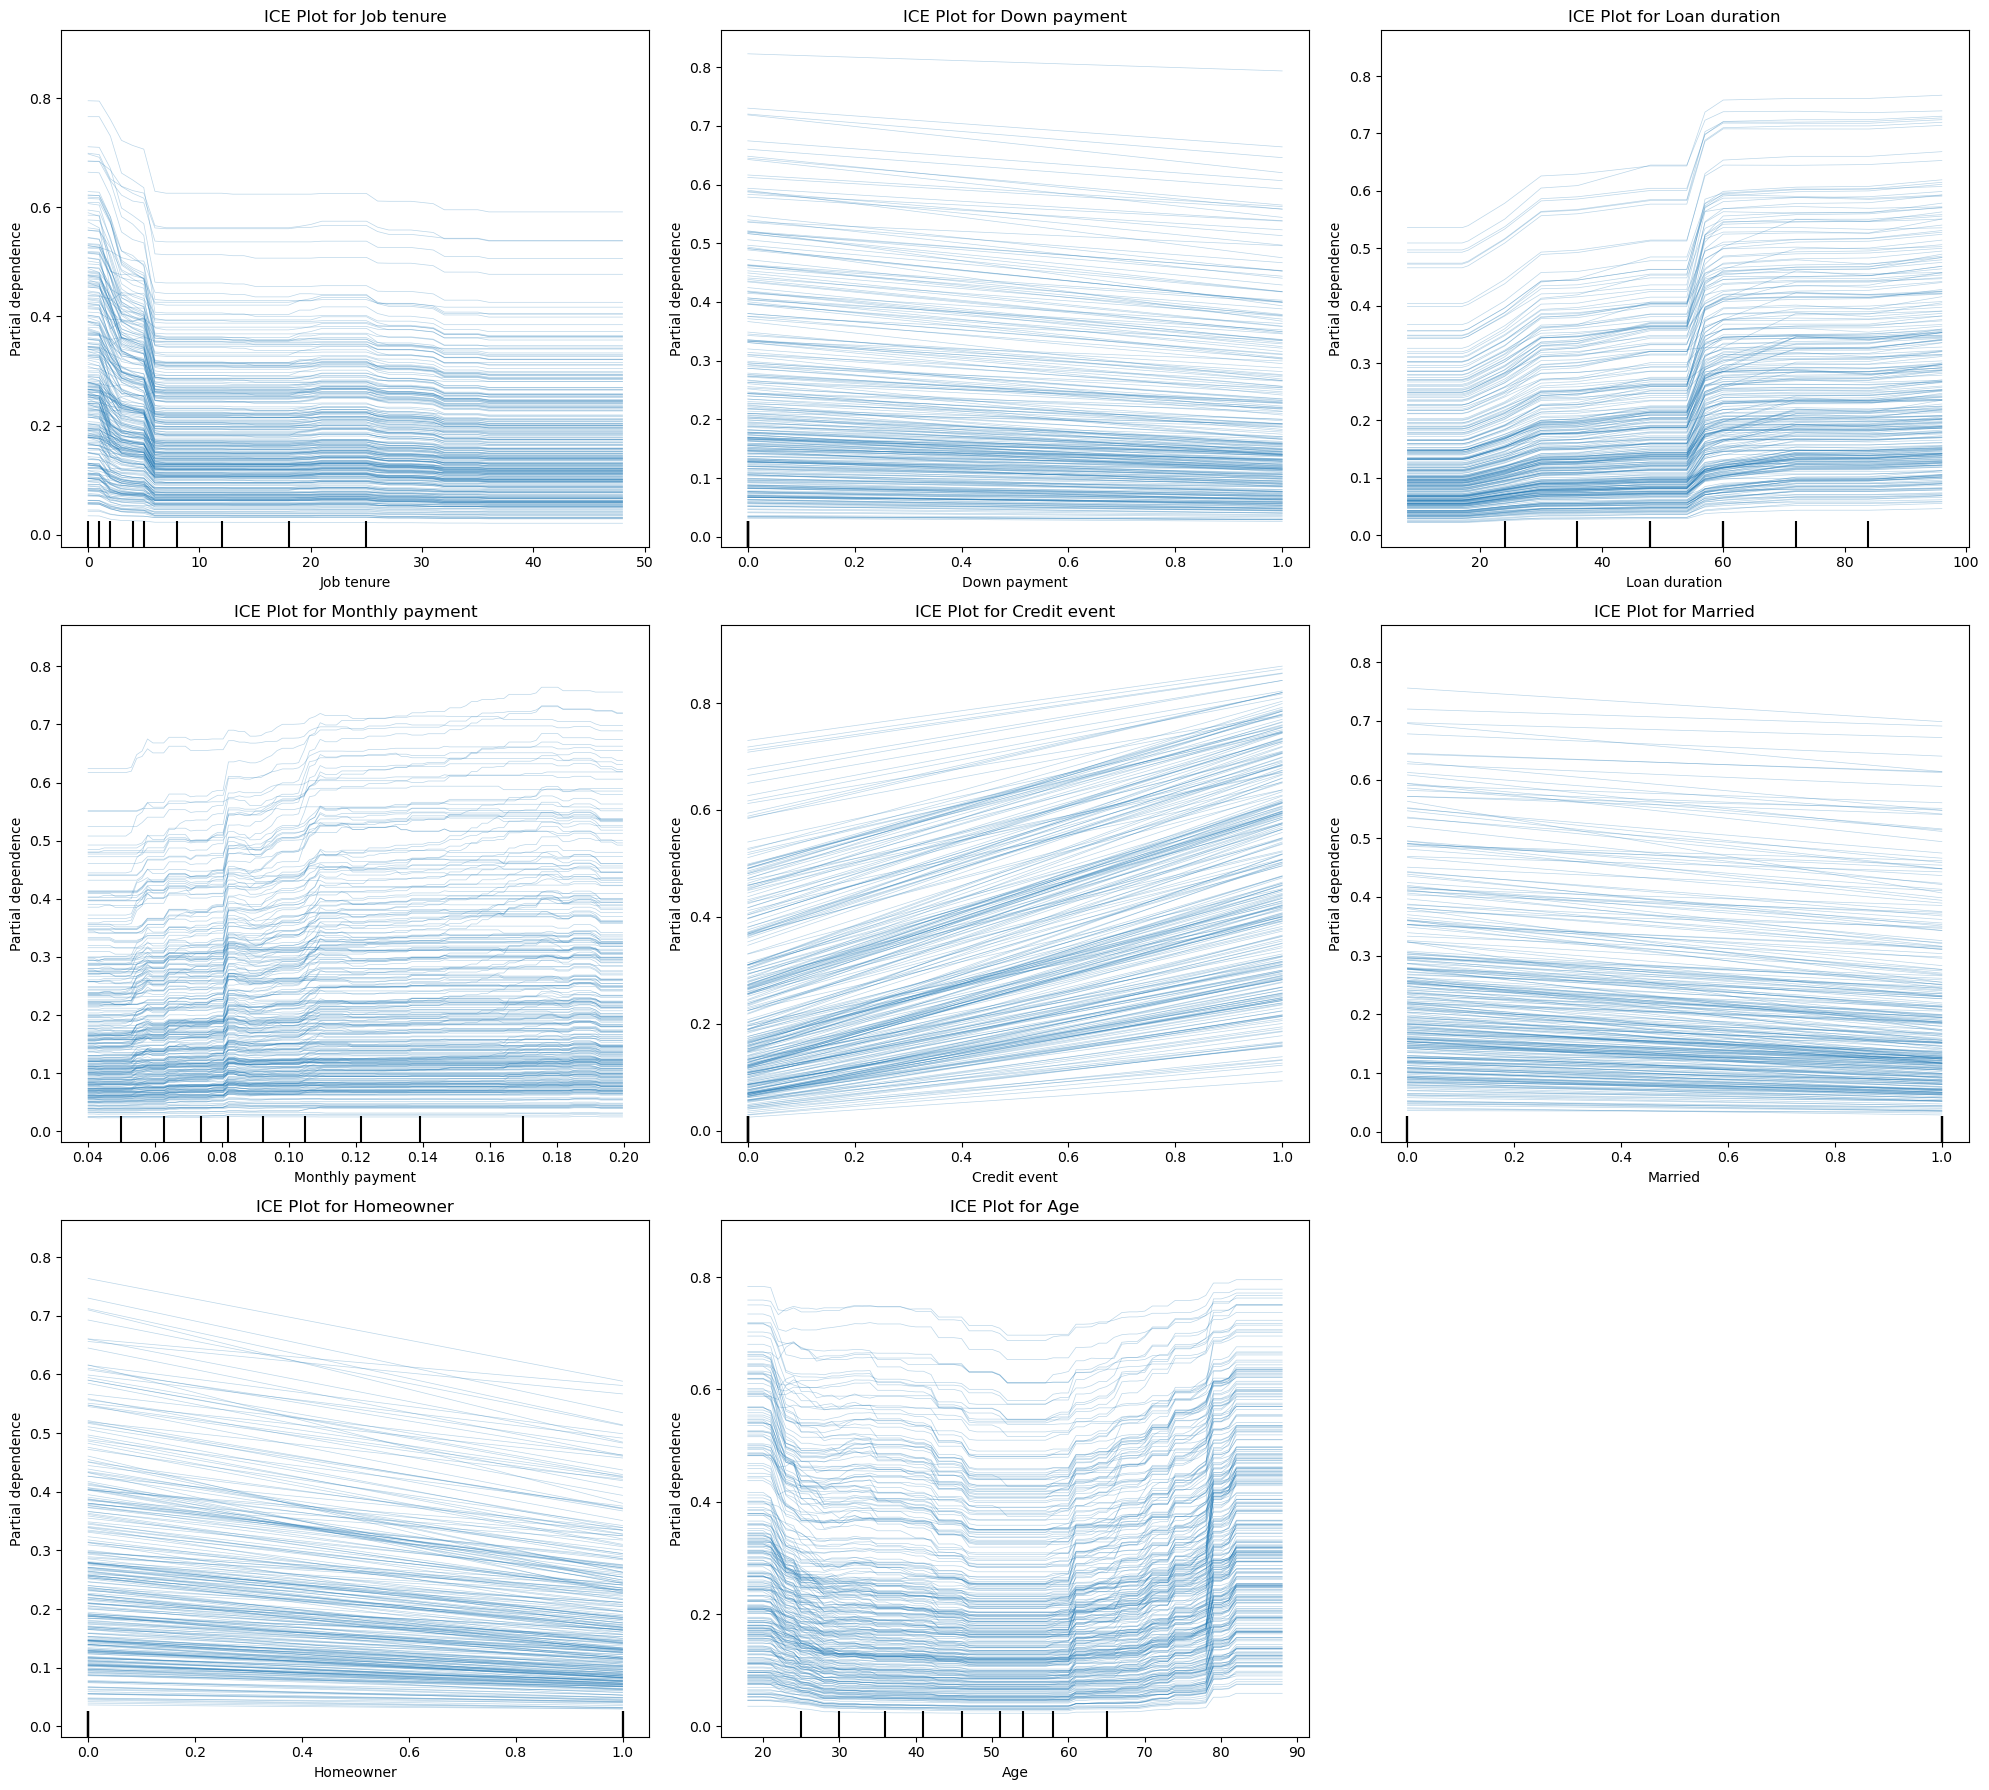

In [120]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Make sure these feature names exactly match the column names in your X_test DataFrame
features = ['Job tenure', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner', 'Age']

n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to ensure all features are included

# Create subplots in a grid
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Generate ICE plot for each feature
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        xgb_model, 
        X_test, 
        [feature],  # Use feature name instead of index
        ax=axs[i], 
        kind='individual', 
        subsample=300,
        n_jobs=-1  # Use all available cores
    )
    axs[i].set_title(f'ICE Plot for {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Predicted Probability of Default')
    axs[i].grid(True)

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

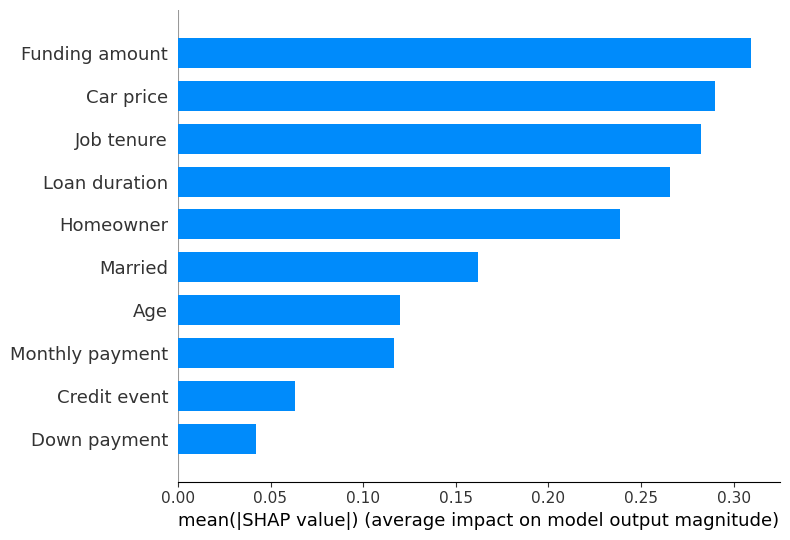

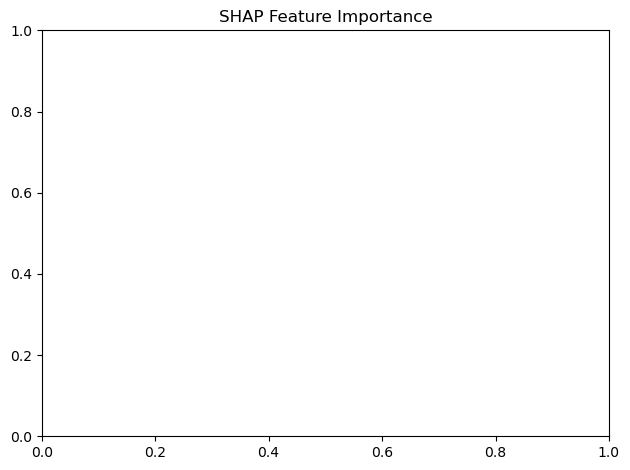

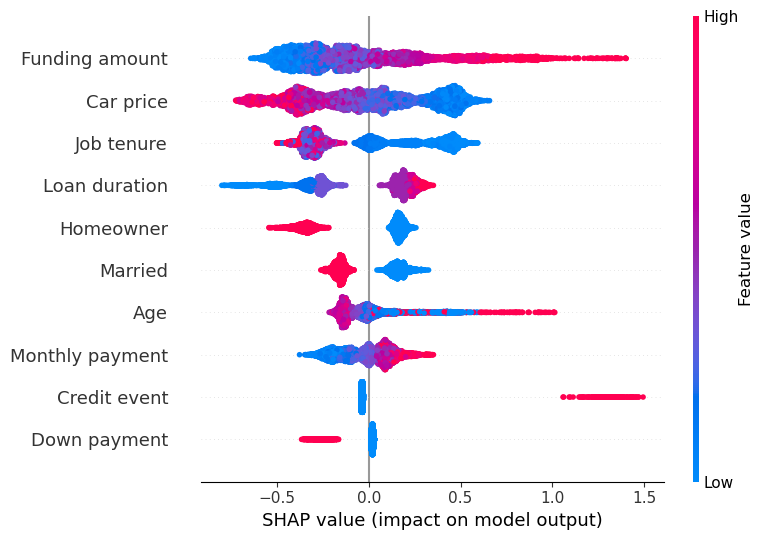

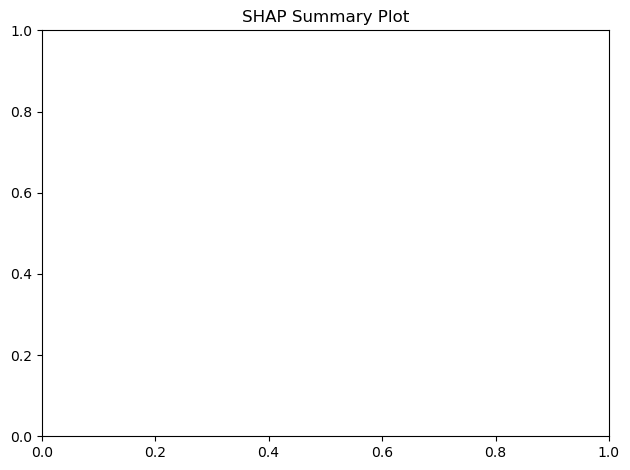

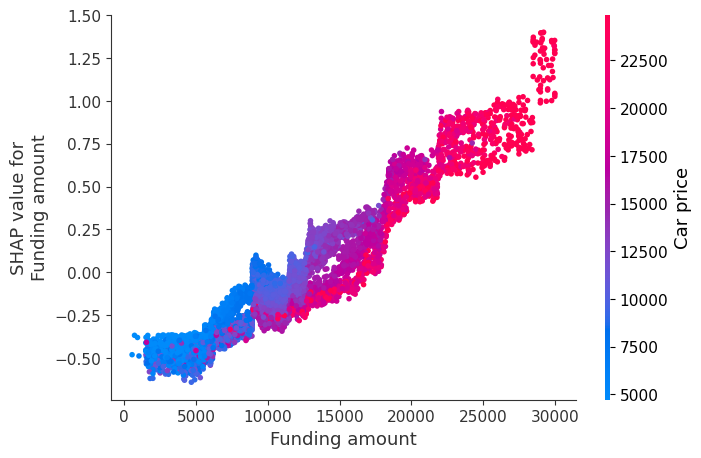

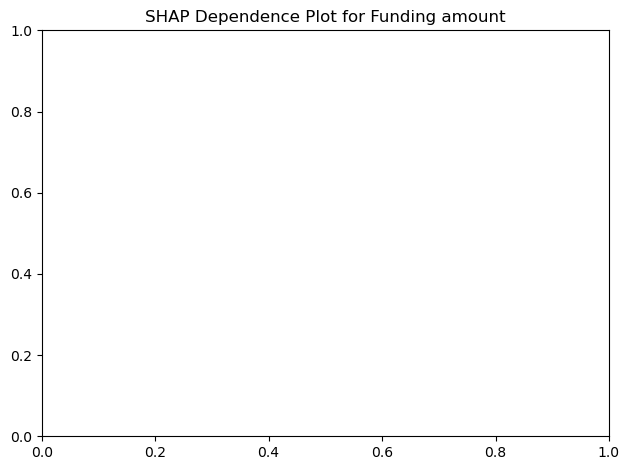

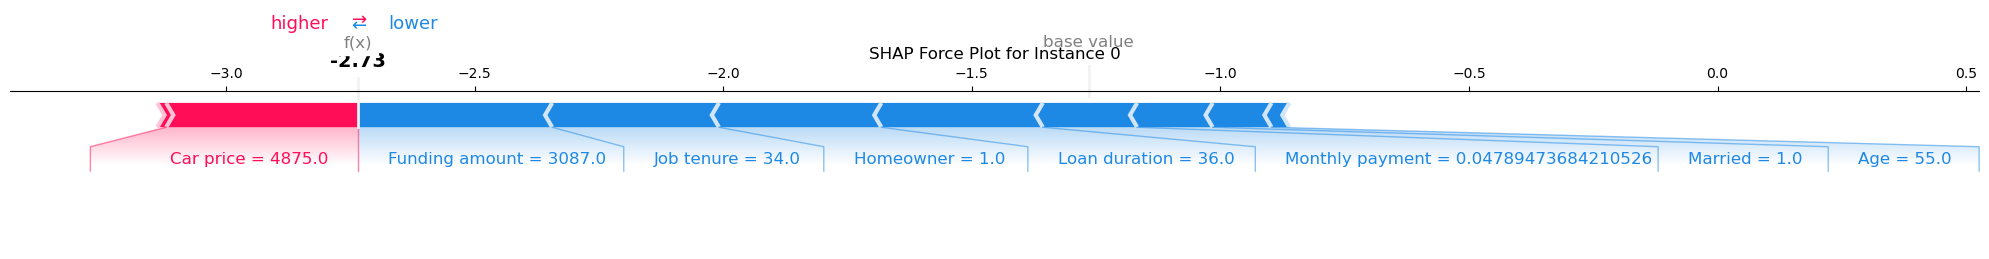

Explaining prediction for instance 0


XGBoostError: [12:20:00] /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/c_api/c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (20 vs. 110) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000015b6031f0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000015b68c708 xgboost::CalcPredictShape(bool, xgboost::PredictionType, unsigned long, unsigned long, unsigned long, unsigned long, unsigned long, std::__1::vector<unsigned long long, std::__1::allocator<unsigned long long>>*, unsigned long long*) + 1216
  [bt] (2) 3   libxgboost.dylib                    0x000000015b68baa8 XGBoosterPredictFromDMatrix + 1260
  [bt] (3) 4   libffi.8.dylib                      0x00000001051a004c ffi_call_SYSV + 76
  [bt] (4) 5   libffi.8.dylib                      0x000000010519d834 ffi_call_int + 1404
  [bt] (5) 6   _ctypes.cpython-311-darwin.so       0x0000000105258134 _ctypes_callproc + 752
  [bt] (6) 7   _ctypes.cpython-311-darwin.so       0x000000010525248c PyCFuncPtr_call + 228
  [bt] (7) 8   python3.11                          0x000000010496d868 _PyEval_EvalFrameDefault + 193188
  [bt] (8) 9   python3.11                          0x000000010493bcf8 _PyEval_Vector + 464



In [127]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X)

# If it's a multi-class problem, shap_values will be a list of arrays, one for each class
# For binary classification or regression, it will be a single array

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Detailed summary plot
shap.summary_plot(shap_values, X)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# SHAP dependence plot for the most important feature
most_important_feature = X.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

# Local explanation for a single instance
instance_index = 0  # You can change this to explain different instances
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X.iloc[instance_index,:], 
                matplotlib=True, show=False)
plt.title(f"SHAP Force Plot for Instance {instance_index}")
plt.tight_layout()
plt.show()

# Function to explain individual predictions
def explain_prediction(instance_index):
    print(f"Explaining prediction for instance {instance_index}")
    instance = X.iloc[instance_index]
    shap_values_instance = explainer.shap_values(instance)
    
    # Print feature values
    print("\nFeature values:")
    for feature, value in instance.items():
        print(f"{feature}: {value}")
    
    # Print SHAP values
    print("\nSHAP values:")
    for feature, shap_value in zip(instance.index, shap_values_instance):
        print(f"{feature}: {shap_value:.4f}")
    
    # Visualize
    shap.force_plot(explainer.expected_value, shap_values_instance, instance, 
                    matplotlib=True, show=False)
    plt.title(f"SHAP Force Plot for Instance {instance_index}")
    plt.tight_layout()
    plt.show()

# Explain a few instances
for i in range(5):  # Explain first 5 instances
    explain_prediction(i)

print("SHAP Implementation Complete")
print("Interpret the results by analyzing the plots and individual explanations.")
print("Look for patterns in feature importance and how they affect predictions.")

## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

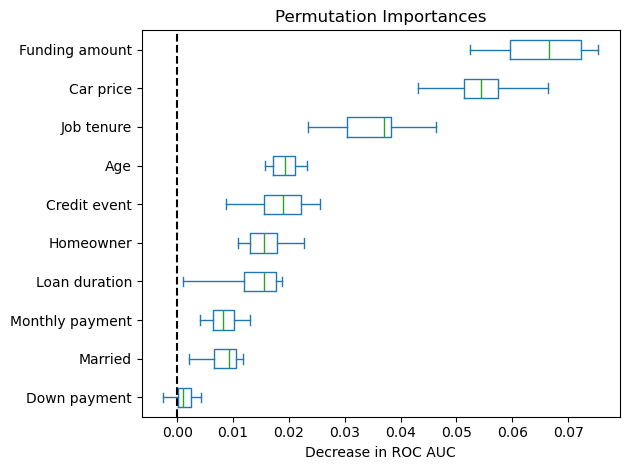

           feature  importance       std
3   Funding amount    0.065664  0.007425
2        Car price    0.055059  0.006585
0       Job tenure    0.034886  0.006913
1              Age    0.019177  0.002481
7     Credit event    0.018444  0.005012
9        Homeowner    0.015983  0.003842
5    Loan duration    0.014065  0.005165
6  Monthly payment    0.008299  0.002542
8          Married    0.008126  0.003127
4     Down payment    0.001154  0.001805

Comparing with SHAP results:
           feature  importance
3   Funding amount    0.309444
2        Car price    0.290019
0       Job tenure    0.282318
5    Loan duration    0.265422
9        Homeowner    0.238571
8          Married    0.162201
1              Age    0.119918
6  Monthly payment    0.116870
7     Credit event    0.063377
4     Down payment    0.042120

Spearman rank correlation between permutation importance and SHAP importance: 0.7333


In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

def plot_permutation_importance(result, feature_names):
    sorted_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_idx].T,
        columns=feature_names[sorted_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in ROC AUC")
    ax.figure.tight_layout()
    plt.show()

# Assuming xgb_model, X_test, y_test are already defined
result = permutation_importance(
    xgb_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Plot the permutation importance results
plot_permutation_importance(result, X_test.columns)

# Print the importance scores
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})
print(importance_df.sort_values('importance', ascending=False))

# Compare with SHAP results
print("\nComparing with SHAP results:")
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(0)
})
shap_importance = shap_importance.sort_values('importance', ascending=False)
print(shap_importance)

# Calculate Spearman rank correlation between permutation importance and SHAP importance
correlation = importance_df['importance'].corr(shap_importance['importance'], method='spearman')
print(f"\nSpearman rank correlation between permutation importance and SHAP importance: {correlation:.4f}")

In [142]:
import XPER

# Initialize XPER with the trained model and performance metric (AUC in this case)
xper = XPER(model=xgb_model, X=X_test, y=y_test, metric=roc_auc_score)

# Compute the feature contributions
feature_contributions = xper.fit()

# Visualize the contributions
xper.plot_contributions()

TypeError: 'module' object is not callable

In [145]:
from XPER.compute.Performance import ModelPerformance

# Define the evaluation metric(s) to be used
XPER_ = ModelPerformance(X_train.values, y_train.values, X_test.values, y_test.values, xgb_model)

# # Evaluate the model performance using the specified metric(s)
# PM = XPER_.evaluate(["AUC"])

# # Print the performance metrics
# print("Performance Metrics: ", round(PM, 3))

# Option 1 - Kernel True
# Calculate XPER values for the model's performance
XPER_values = XPER_.calculate_XPER_values(["AUC"])

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

30


ValueError: Feature shape mismatch, expected: 10, got 5

## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

## Step 10: Implement a FPDP using a fairness measure. Discuss your results.